# Spam Detector with NLTK and ML

**Objective:**<br />

- In this notebook, I will implement all the functions required to build a binary classification model to classify spam.

**After this code:**<br />

- I'll have a trained model to predict texts in two categories (Spam or not). For this, I used mainly `sklearn` and `nltk` packages.


Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this code.

- **pandas** is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
- **numPy** is a Python library used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices.
- **string** provides additional tools to manipulate strings.
- **nltk** is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning and wrappers for industrial-strength NLP libraries.
- **scikit-learn** is a free machine learning library for Python.
- **matplotlib** is a comprehensive library for creating static, animated, and interactive visualizations in Python.
- **itertools** is a module in python, it is used to iterate over data structures that can be stepped over using a for-loop. Such data structures are also known as iterables. This module incorporates functions that utilize computational resources efficiently.

In [1]:
import pandas as pd
import numpy as np
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import product

In [ ]:
# Needed to work use the function
nltk.download('punkt') # punctuation
nltk.download('stopwords') # stopwords
nltk.download('wordnet') # lemmatize

## 2 - Creating function to preprocess texts

Here, I built a function to tokenize, remove stopwords and short words and, finally, lemmatize words. In order to test this function, I wrote one text to see what would be the final result.

In [3]:
def preprocessing_text(text):
    
    # Tokenize the whole string
    words = word_tokenize(text)
    
    # Remove punctuation
    tokens = [w for w in words if w.lower() not in string.punctuation]
    
    # Get list of stopwords
    # Though "stop words" usually refers to the most common words in a language.
    stopw = stopwords.words('english')
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopw]
    
    # Remove words less than three letters
    tokens = [word for word in tokens if len(word)>=3] 
    
    # lemmatize:
    # In linguistics, is the process of grouping together the inflected forms of a word so they
    # can be analysed as a single item, identified by the word's lemma, or dictionary form.
    lemma = WordNetLemmatizer() 
    tokens = [lemma.lemmatize(word) for word in tokens]
    
    # Gathering all words
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [4]:
example_text_before = "I'm gonna be home soon and I don't want to talk about this stuff anymore tonight, ok? I've cried enough today."

In [5]:
example_text_after = preprocessing_text(example_text_before)
print('>> Text before processing:\n', example_text_before)
print('')
print('<< Text after processing:\n', example_text_after)

>> Text before processing:
 I'm gonna be home soon and I don't want to talk about this stuff anymore tonight, ok? I've cried enough today.

<< Text after processing:
 gon home soon n't want talk stuff anymore tonight 've cried enough today


## 3 - Import data

In [6]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
df = pd.read_csv(url, sep ='\t',names=["class", "text"])
print(df.shape)
df.head(10)

(5572, 2)


,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [7]:
%%time
# Applying the created function
df['text_preproc'] = df['text'].apply(preprocessing_text)
df.head(10)

Wall time: 2.42 s


,class,text,text_preproc
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy Available bugis great world...
1,ham,Ok lar... Joking wif u oni...,lar ... Joking wif oni ...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry wkly comp win Cup final tkts 21st M...
3,ham,U dun say so early hor... U c already then say...,dun say early hor ... already say ...
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah n't think go usf life around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,FreeMsg Hey darling week word back like fun st...
6,ham,Even my brother is not like to speak with me. ...,Even brother like speak They treat like aid pa...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,per request 'Melle Melle Oru Minnaminunginte N...
8,spam,WINNER!! As a valued network customer you have...,WINNER valued network customer selected receiv...
9,spam,Had your mobile 11 months or more? U R entitle...,Had mobile month entitled Update latest colour...


## 3 - Split into train and test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['text_preproc'], df['class'], test_size=0.2, random_state= 13)

In [12]:
print("Train Dataset")
print("%d documents" % len(X_train))
print("%d categories" % len(y_train.unique()))

Train Dataset
4457 documents
2 categories


In [13]:
print("Test Dataset")
print("%d documents" % len(X_test))
print("%d categories" % len(y_test.unique()))

Test Dataset
1115 documents
2 categories


## 5 - Feature Extraction

In [15]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                             smooth_idf=True,
                             min_df=0.0025,
                             max_df=0.1,
                             norm='l2',
                             ngram_range=(1,2),
                             strip_accents='unicode',
                             stop_words='english')

In [16]:
X_train_vec = vectorizer.fit_transform(X_train)

print("Train Dataset")
print("Number of samples: %d, number of features: %d" % X_train_vec.shape)

Train Dataset
Number of samples: 4457, number of features: 570


In [17]:
X_test_vec = vectorizer.transform(X_test)

print("Test Dataset")
print("Number of samples: %d, number of features: %d" % X_test_vec.shape)

Test Dataset
Number of samples: 1115, number of features: 570


In [18]:
# Weight for each word
weights = np.asarray(X_train_vec.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
110,come,0.018851
275,like,0.017089
204,got,0.017044
281,ll,0.016939
257,know,0.016895
485,time,0.016380
201,good,0.016022
528,want,0.015794
131,day,0.014670
198,going,0.013577


## 6 - Machine Learning

In [19]:
# Print the confusion matrix
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### 6.1 - Naive Bayes Classifier

A Naive Bayes classifier is a simple probabilistic classifier based on applying Bayes' theorem (from Bayesian
statistics) with strong (naive) independence assumptions.

In [20]:
%%time
clf_NB = MultinomialNB()
clf_NB = clf_NB.fit(X_train_vec, y_train)

Wall time: 8.98 ms


In [21]:
y_train_pred = clf_NB.predict(X_train_vec)
y_test_pred = clf_NB.predict(X_test_vec)

In [22]:
# Classification Report
print("Classification Report - Train")
print("Train accuracy score:", metrics.accuracy_score(y_train, y_train_pred))
print(metrics.classification_report(y_train, y_train_pred))

print("Classification Report - Test")
print("Test accuracy score:", metrics.accuracy_score(y_test, y_test_pred))
print(metrics.classification_report(y_test, y_test_pred))

Classification Report - Train
Train accuracy score: 0.9789095804352703
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      3864
        spam       0.98      0.86      0.92       593

    accuracy                           0.98      4457
   macro avg       0.98      0.93      0.95      4457
weighted avg       0.98      0.98      0.98      4457

Classification Report - Test
Test accuracy score: 0.9730941704035875
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       961
        spam       0.96      0.84      0.90       154

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



Confusion matrix, without normalization


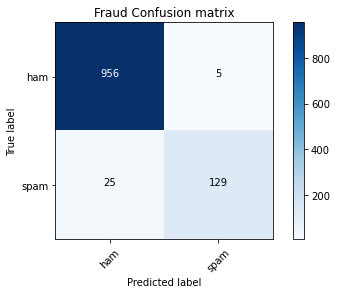

In [23]:
# Create a confusion matrix
km_cm = metrics.confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm, classes=['ham', 'spam'])

### 6.2 - Support Vector Machines

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. The advantages of support vector machines are: Effective in high dimensional spaces. Still effective in cases where number of dimensions is greater than the number of samples.

In [24]:
%%time
svm_clf = SVC(kernel='rbf', gamma=1.0, C=1000, random_state=13)
svm_clf = svm_clf.fit(X_train_vec, y_train)

Wall time: 261 ms


In [25]:
y_train_pred = svm_clf.predict(X_train_vec)
y_test_pred = svm_clf.predict(X_test_vec)

In [26]:
# Classification Report
print("Classification Report - Train")
print("Train accuracy score:", metrics.accuracy_score(y_train, y_train_pred))
print(metrics.classification_report(y_train, y_train_pred))

print("Classification Report - Test")
print("Test accuracy score:", metrics.accuracy_score(y_test, y_test_pred))
print(metrics.classification_report(y_test, y_test_pred))

Classification Report - Train
Train accuracy score: 0.9988781691720888
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3864
        spam       1.00      0.99      1.00       593

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457

Classification Report - Test
Test accuracy score: 0.9847533632286996
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       961
        spam       0.98      0.91      0.94       154

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



Confusion matrix, without normalization


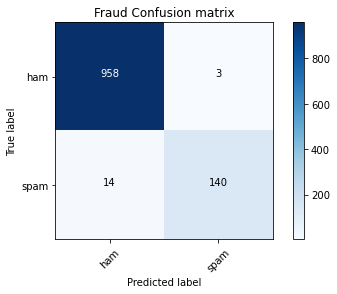

In [27]:
# Create a confusion matrix
km_cm = metrics.confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm, classes=['ham', 'spam'])

### 6.3 - Random Forest

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

In [28]:
%%time
rf_clf = RandomForestClassifier(criterion='gini',
                                #max_depth=8,
                                n_estimators=1000,
                                n_jobs=-1,
                                random_state=13)
rf_clf = rf_clf.fit(X_train_vec, y_train)

Wall time: 1.97 s


In [29]:
y_train_pred = rf_clf.predict(X_train_vec)
y_test_pred = rf_clf.predict(X_test_vec)

In [30]:
# Classification Report
print("Classification Report - Train")
print("Train accuracy score:", metrics.accuracy_score(y_train, y_train_pred))
print(metrics.classification_report(y_train, y_train_pred))

print("Classification Report - Test")
print("Test accuracy score:", metrics.accuracy_score(y_test, y_test_pred))
print(metrics.classification_report(y_test, y_test_pred))

Classification Report - Train
Train accuracy score: 0.9988781691720888
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3864
        spam       1.00      0.99      1.00       593

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457

Classification Report - Test
Test accuracy score: 0.9829596412556054
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       961
        spam       0.99      0.89      0.94       154

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Confusion matrix, without normalization


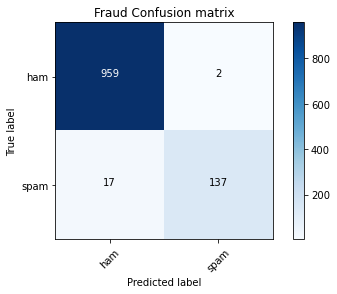

In [31]:
# Create a confusion matrix
km_cm = metrics.confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm, classes=['ham', 'spam'])

### 6.4 - Gradient Boosting

Gradient boosting is a machine learning technique for regression and classification problems that produce a prediction model in the form of an ensemble of weak prediction models. The idea of gradient boosting is that you can combine a group of relatively weak prediction models to build a stronger prediction model.

In [32]:
%%time
gb_clf = GradientBoostingClassifier(learning_rate=0.001, n_estimators=10000, random_state=13)
gb_clf = gb_clf.fit(X_train_vec, y_train)

Wall time: 38.2 s


In [33]:
y_train_pred = gb_clf.predict(X_train_vec)
y_test_pred = gb_clf.predict(X_test_vec)

In [34]:
# Classification Report
print("Classification Report - Train")
print("Train accuracy score:", metrics.accuracy_score(y_train, y_train_pred))
print(metrics.classification_report(y_train, y_train_pred))

print("Classification Report - Test")
print("Test accuracy score:", metrics.accuracy_score(y_test, y_test_pred))
print(metrics.classification_report(y_test, y_test_pred))

Classification Report - Train
Train accuracy score: 0.974646623289208
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3864
        spam       0.99      0.81      0.90       593

    accuracy                           0.97      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.97      0.97      4457

Classification Report - Test
Test accuracy score: 0.9632286995515695
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       961
        spam       0.99      0.74      0.85       154

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115



Confusion matrix, without normalization


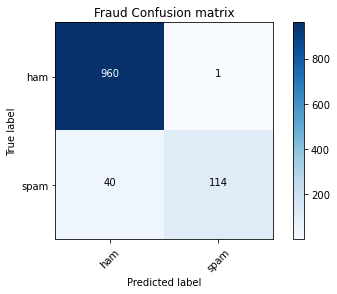

In [35]:
# Create a confusion matrix
km_cm = metrics.confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm, classes=['ham', 'spam'])

### 6.5 - Voting Classifier

A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.
It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting.

In [36]:
%%time
# Define the three classifiers to use in the ensemble
clf1 = MultinomialNB()
clf2 = SVC(kernel='rbf', gamma=1.0, C=1000, probability=True, random_state=13)
clf3 = RandomForestClassifier(random_state=13)
clf4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=5000, random_state=13)

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('nb', clf1), ('svc', clf2), ('rf', clf3), ('gb', clf4)], voting='soft')
ensemble_model.fit(X_train_vec, y_train)

Wall time: 20.5 s


VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('svc',
                              SVC(C=1000, gamma=1.0, probability=True,
                                  random_state=13)),
                             ('rf', RandomForestClassifier(random_state=13)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.005,
                                                         n_estimators=5000,
                                                         random_state=13))],
                 voting='soft')

In [37]:
y_train_pred = ensemble_model.predict(X_train_vec)
y_test_pred = ensemble_model.predict(X_test_vec)

In [38]:
# Classification Report
print("Classification Report - Train")
print("Train accuracy score:", metrics.accuracy_score(y_train, y_train_pred))
print(metrics.classification_report(y_train, y_train_pred))

print("Classification Report - Test")
print("Test accuracy score:", metrics.accuracy_score(y_test, y_test_pred))
print(metrics.classification_report(y_test, y_test_pred))

Classification Report - Train
Train accuracy score: 0.9964101413506843
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3864
        spam       1.00      0.97      0.99       593

    accuracy                           1.00      4457
   macro avg       1.00      0.99      0.99      4457
weighted avg       1.00      1.00      1.00      4457

Classification Report - Test
Test accuracy score: 0.9847533632286996
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       961
        spam       0.99      0.90      0.94       154

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



Confusion matrix, without normalization


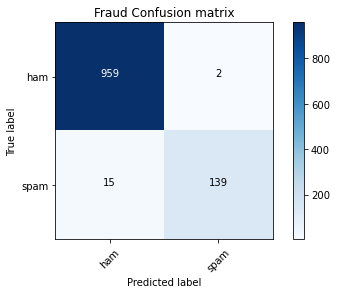

In [39]:
# Create a confusion matrix
km_cm = metrics.confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm, classes=['ham', 'spam'])

-----------------------